## MPF training

Below is my test code to use MPF training for a fully-connected Boltzmann machine with 32 units with no GPU consideration.

In [7]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

import os
import timeit

%matplotlib inline

In [8]:
def load_data(dataset = '32-50K.npy', borrow = True):
    """
    Loads the dataset.
    """

    data = np.load(dataset)
    dataset = theano.shared(np.asarray(data, dtype = theano.config.floatX), borrow = borrow)

    return dataset

In [12]:
class mpf(object):
    """
    Minimum probability flow
    """
    
    def __init__(self, input = None, n = 32, temperature = 1,  W = None, b = None):
        
        self.n = n
        self.temperature = temperature
        U = np.random.rand(self.n, self.n)
        R = 0.5 * (U + U.T)
        np.fill_diagonal(R, 0)

        if not W:
            initial_W = np.asarray(R, dtype = theano.config.floatX)
            W = theano.shared(initial_W, name = 'W', borrow = True)

        if not b:
            initial_b = np.asarray(np.random.rand(n), dtype = theano.config.floatX)
            b = theano.shared(initial_b, name = 'b', borrow = True)


        self.W = W
        self.b = b
        
        if input is None:
            self.x = T.dmatrix(name = 'input')
        else:
            self.x = input

        self.params = [self.W, self.b]
    
    
    def cost(self, lr = 1e-2, epsilon = 1):
        """
        Returns the cost of vanilla SGD. 
        The update rule enforces that the W matrix at each timestep is symmetric.
        """
         
        print (51 * '=')
        print (24 * '#' + 'MPF' + 24 * '#')
        print (51 * '=')
        print ('Input size: {0}'.format(self.n))
        print ('Learning temperature: {0}'.format(self.temperature))
        print ('Learning rate: {0}'.format(lr))
        
        cost = T.mean(T.exp((0.5 - self.x) * (T.dot(self.x, self.W) + self.b))) * epsilon
        Wgrad = T.grad(cost, self.W)
        bgrad = T.grad(cost, self.b)

        Wupdate = T.fill_diagonal(0.5 * ((self.W - lr * Wgrad) + (self.W - lr * Wgrad).T), 0)
        updates = [(self.W, Wupdate), (self.b, self.b - lr * bgrad )]
#         bupdate = self.b - lr *(T.diag(0.5 * ((self.W - lr * Wgrad) + (self.W - lr * Wgrad).T)) + bgrad)
#         Wupdate = T.fill_diagonal(0.5 * ((self.W - lr * Wgrad) + (self.W - lr * Wgrad).T), 0)        
#         updates = [(self.W, Wupdate), (self.b, bupdate)]

        return cost, updates

In [13]:
def trainmpf(units = 32, lr = 1e-2, epsilon = 1, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '32-50K.npy'):
    """
    Trains parameters using MPF.
    """
    
    index = T.lscalar()
    x = T.matrix('x')
    flow = mpf(input = x, n = units, temperature = temperature)
    
    cost, updates = flow.cost(lr = lr, epsilon = epsilon)
    
    dataset = load_data(sample)
    n_dataset_batches = dataset.get_value(borrow = True).shape[0] // batchsize

    print ('Sample used: {0}'.format(sample))
    print ('=' * 51)
    
    mpf_cost = theano.function(inputs = [index], outputs = cost, updates = updates, \
                                givens = {x: dataset[index * batchsize: (index + 1) * batchsize]})
    
    start_time = timeit.default_timer()
    
    best_mse = np.inf
    best_W = [None, np.inf]
    best_b = [None, np.inf]
    
    for epoch in range(n_epochs):
        c = []
        current_time = timeit.default_timer()
        for batch_index in range(n_dataset_batches):
            c.append(mpf_cost(batch_index))
        
        W_learnt = flow.W.get_value(borrow = True)
        b_learnt = flow.b.get_value(borrow = True)
        
        W = np.load(sample[0:2] + '-' + 'W' + '.npy')
        b = np.load(sample[0:2] + '-' + 'b' + '.npy')
        
        mseW = np.linalg.norm(W - W_learnt)/ (units**2 - units)/2
        mseb = np.linalg.norm(b - b_learnt)/ units
#         mse = (mseW * mseb)/(mseW + mseb)
        mse = mseW + mseb    
    
        if mse < best_mse:
            best_mse = mse
            best_W[0] = flow.W.get_value(borrow = True)
            best_W[1] = mseW
            best_b[0] = flow.b.get_value(borrow = True)
            best_b[1] = mseb
            best_cost = np.mean(c, dtype='float64')
            best_epoch = epoch
        
        if epoch%validate_every == 0:
            print ('Training epoch %d/%d, Cost: %f mseW: %.5f, mseb: %.5f, mse: %.5f Time Elasped: %.2f '\
                 % (epoch, n_epochs, np.mean(c, dtype='float64'), \
                 mseW, mseb, mse, (current_time - start_time)/60) )
    
    end_time = timeit.default_timer()

    training_time = end_time - start_time
    
    fig, ax = plt.subplots(2, figsize=(20,10))
    fig.tight_layout()

    ax[0].plot(W.reshape(-1,1)[0:100], 'b')
    ax[0].plot(W_learnt.reshape(-1,1)[0:100], 'r')
    ax[0].set_title('W')
    ax[0].legend(['W', 'Learnt W'])
    ax[1].plot(b.reshape(-1,1), 'b')
    ax[1].plot(b_learnt.reshape(-1,1),'r')
    ax[1].set_title('b')
    ax[1].legend(['b', 'Learnt b'])
    
    print ('The training took %.2f minutes' % (training_time/60.))
    print ('#' * 22 + 'Results' + '#' * 22)
    print ('=' * 51)
    print ('Best mse: {0}'.format(mse))
    print ('Best W mse: {0}'.format(mseW))
    print ('Best b mse: {0}'.format(mseb))
    print ('=' * 51)

########################MPF########################
Input size: 32
Learning temperature: 1
Learning rate: 0.01
Sample used: 32-50K.npy
Training epoch 0/1000, Cost: 1.803821 mseW: 0.01135, mseb: 0.19068, mse: 0.20202 Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.455443 mseW: 0.00714, mseb: 0.16016, mse: 0.16729 Time Elasped: 0.57 
Training epoch 200/1000, Cost: 0.451425 mseW: 0.00612, mseb: 0.15365, mse: 0.15977 Time Elasped: 1.03 
Training epoch 300/1000, Cost: 0.450117 mseW: 0.00555, mseb: 0.14929, mse: 0.15484 Time Elasped: 1.48 
Training epoch 400/1000, Cost: 0.449470 mseW: 0.00518, mseb: 0.14601, mse: 0.15119 Time Elasped: 1.93 
Training epoch 500/1000, Cost: 0.449089 mseW: 0.00491, mseb: 0.14348, mse: 0.14839 Time Elasped: 2.37 
Training epoch 600/1000, Cost: 0.448841 mseW: 0.00471, mseb: 0.14150, mse: 0.14621 Time Elasped: 2.82 
Training epoch 700/1000, Cost: 0.448666 mseW: 0.00455, mseb: 0.13995, mse: 0.14450 Time Elasped: 3.26 
Training epoch 800/1000, Cost: 0.448537 mse

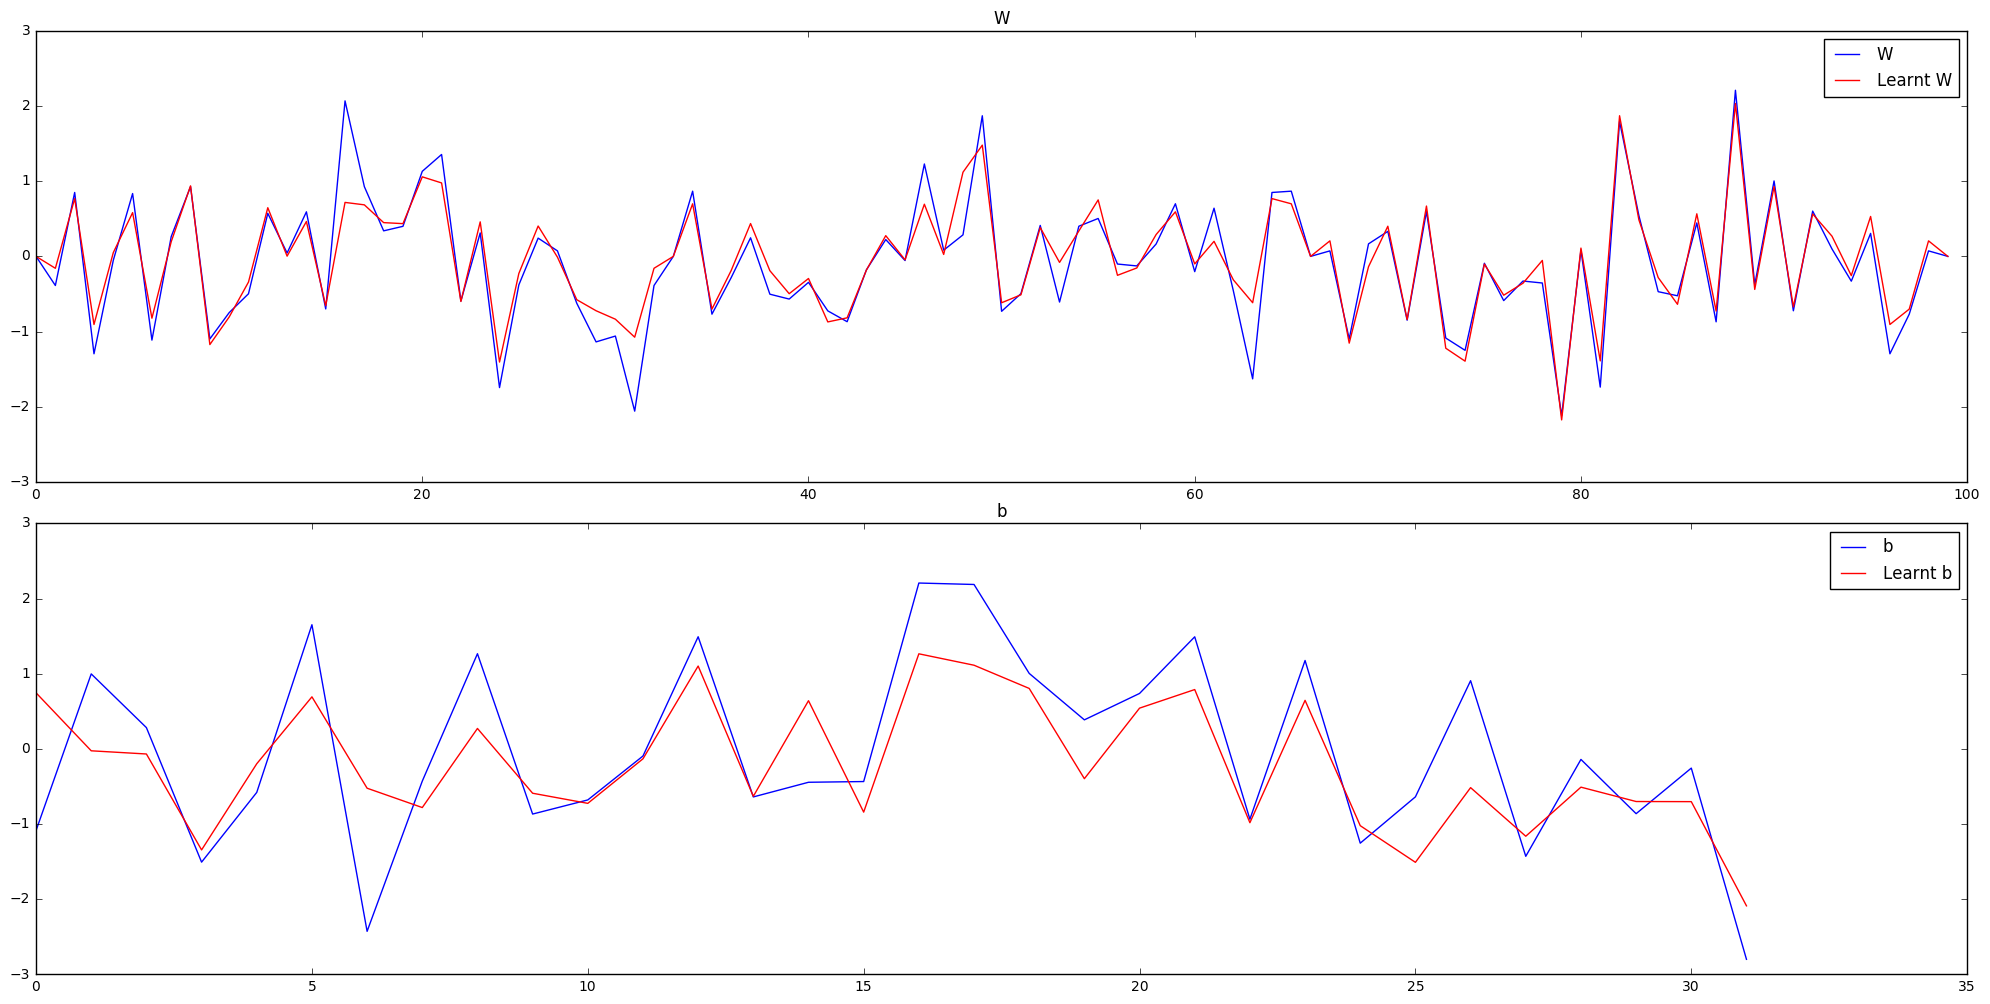

In [5]:
trainmpf(units = 32, lr = 1e-2, epsilon = 1, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '32-50K.npy')

########################MPF########################
Input size: 32
Learning temperature: 1
Learning rate: 0.001
Sample used: 32-50K.npy
Training epoch 0/1000, Cost: 8.403002 mseW: 0.01270, mseb: 0.21136, mse: 0.22406 Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.506755 mseW: 0.01034, mseb: 0.19388, mse: 0.20422 Time Elasped: 0.47 
Training epoch 200/1000, Cost: 0.485333 mseW: 0.00959, mseb: 0.18909, mse: 0.19869 Time Elasped: 0.92 
Training epoch 300/1000, Cost: 0.474646 mseW: 0.00907, mseb: 0.18574, mse: 0.19481 Time Elasped: 1.37 
Training epoch 400/1000, Cost: 0.468407 mseW: 0.00867, mseb: 0.18315, mse: 0.19182 Time Elasped: 1.81 
Training epoch 500/1000, Cost: 0.464391 mseW: 0.00834, mseb: 0.18104, mse: 0.18938 Time Elasped: 2.26 
Training epoch 600/1000, Cost: 0.461620 mseW: 0.00807, mseb: 0.17926, mse: 0.18733 Time Elasped: 2.69 
Training epoch 700/1000, Cost: 0.459609 mseW: 0.00784, mseb: 0.17772, mse: 0.18556 Time Elasped: 3.10 
Training epoch 800/1000, Cost: 0.458089 ms

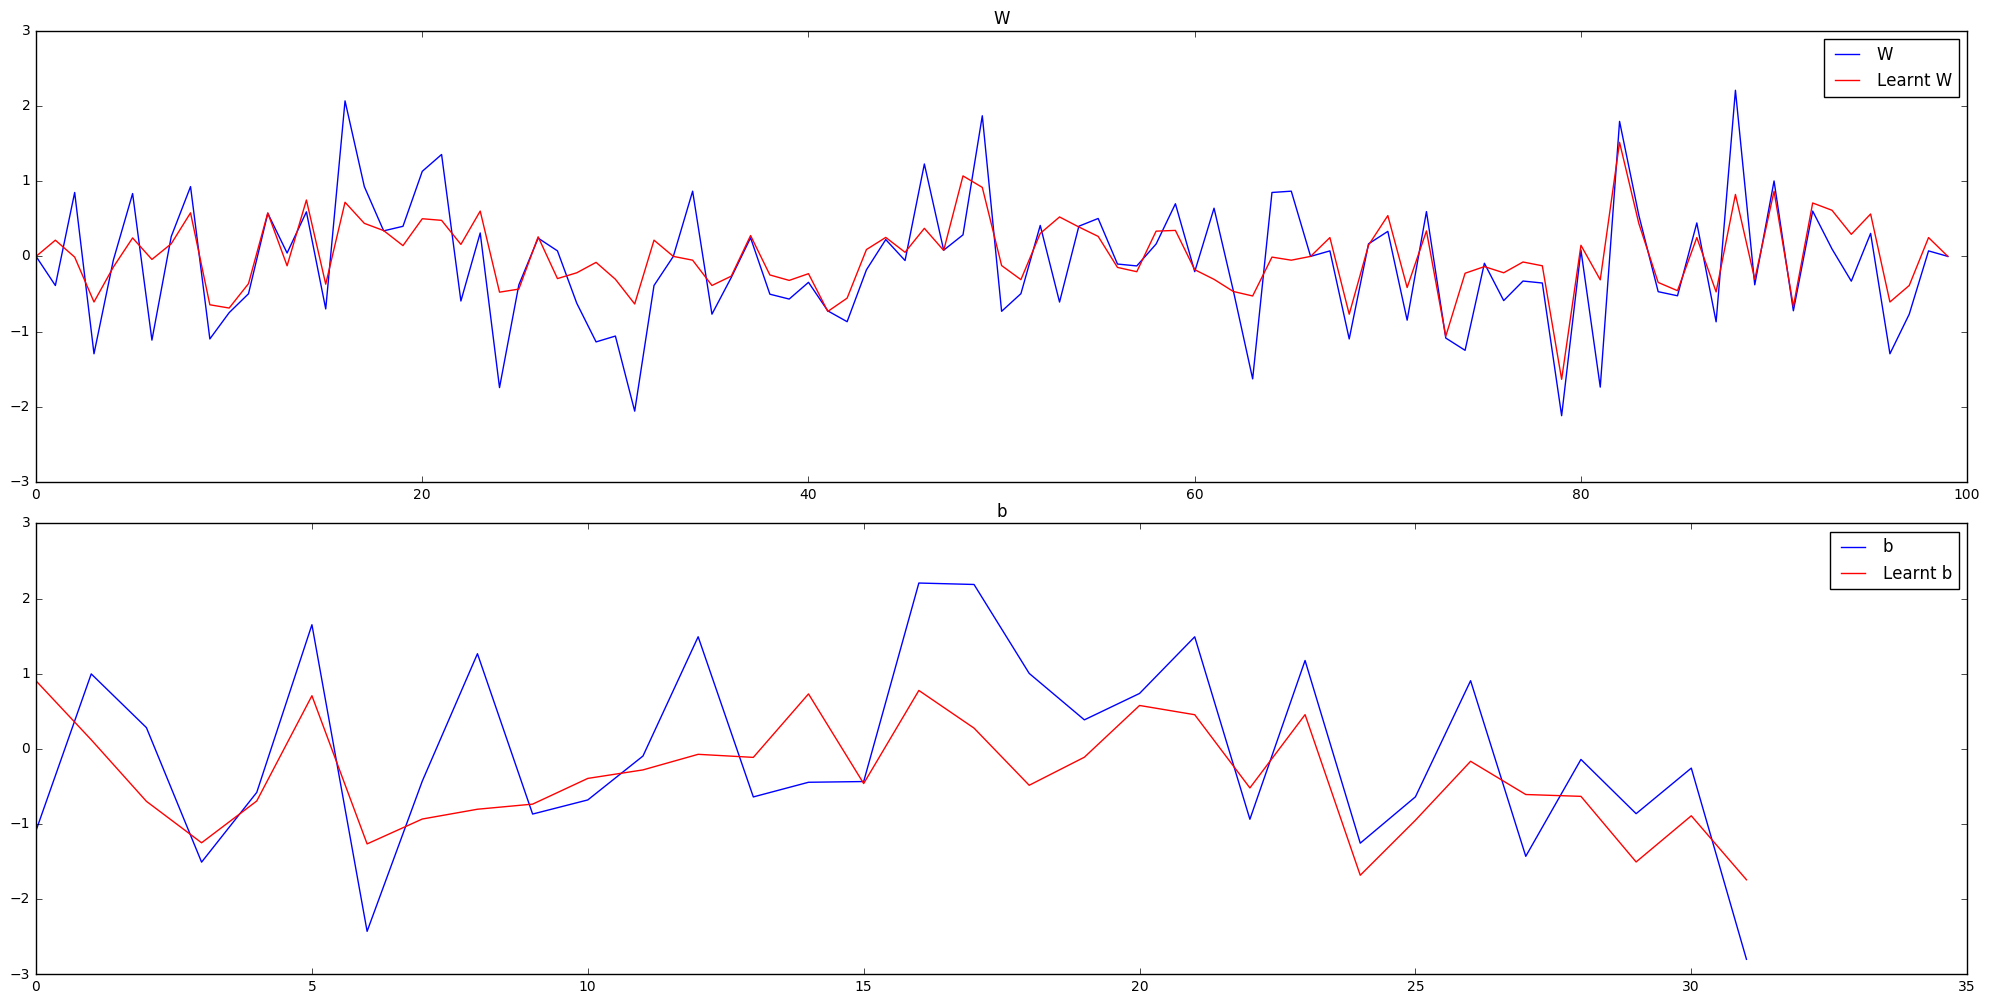

In [6]:
trainmpf(units = 32, lr = 1e-3, epsilon = 1, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '32-50K.npy')

########################MPF########################
Input size: 32
Learning temperature: 1
Learning rate: 0.01
Sample used: 32-50K.npy
Training epoch 0/1000, Cost: 1.732681 mseW: 0.01131, mseb: 0.20139, mse: 0.21270 Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.455812 mseW: 0.00722, mseb: 0.16875, mse: 0.17597 Time Elasped: 3.19 
Training epoch 200/1000, Cost: 0.451671 mseW: 0.00616, mseb: 0.16107, mse: 0.16723 Time Elasped: 3.81 
Training epoch 300/1000, Cost: 0.450272 mseW: 0.00556, mseb: 0.15592, mse: 0.16148 Time Elasped: 4.20 
Training epoch 400/1000, Cost: 0.449574 mseW: 0.00516, mseb: 0.15207, mse: 0.15723 Time Elasped: 4.60 
Training epoch 500/1000, Cost: 0.449163 mseW: 0.00487, mseb: 0.14913, mse: 0.15400 Time Elasped: 5.00 
Training epoch 600/1000, Cost: 0.448895 mseW: 0.00466, mseb: 0.14685, mse: 0.15151 Time Elasped: 5.39 
Training epoch 700/1000, Cost: 0.448707 mseW: 0.00450, mseb: 0.14508, mse: 0.14957 Time Elasped: 5.81 
Training epoch 800/1000, Cost: 0.448569 mse

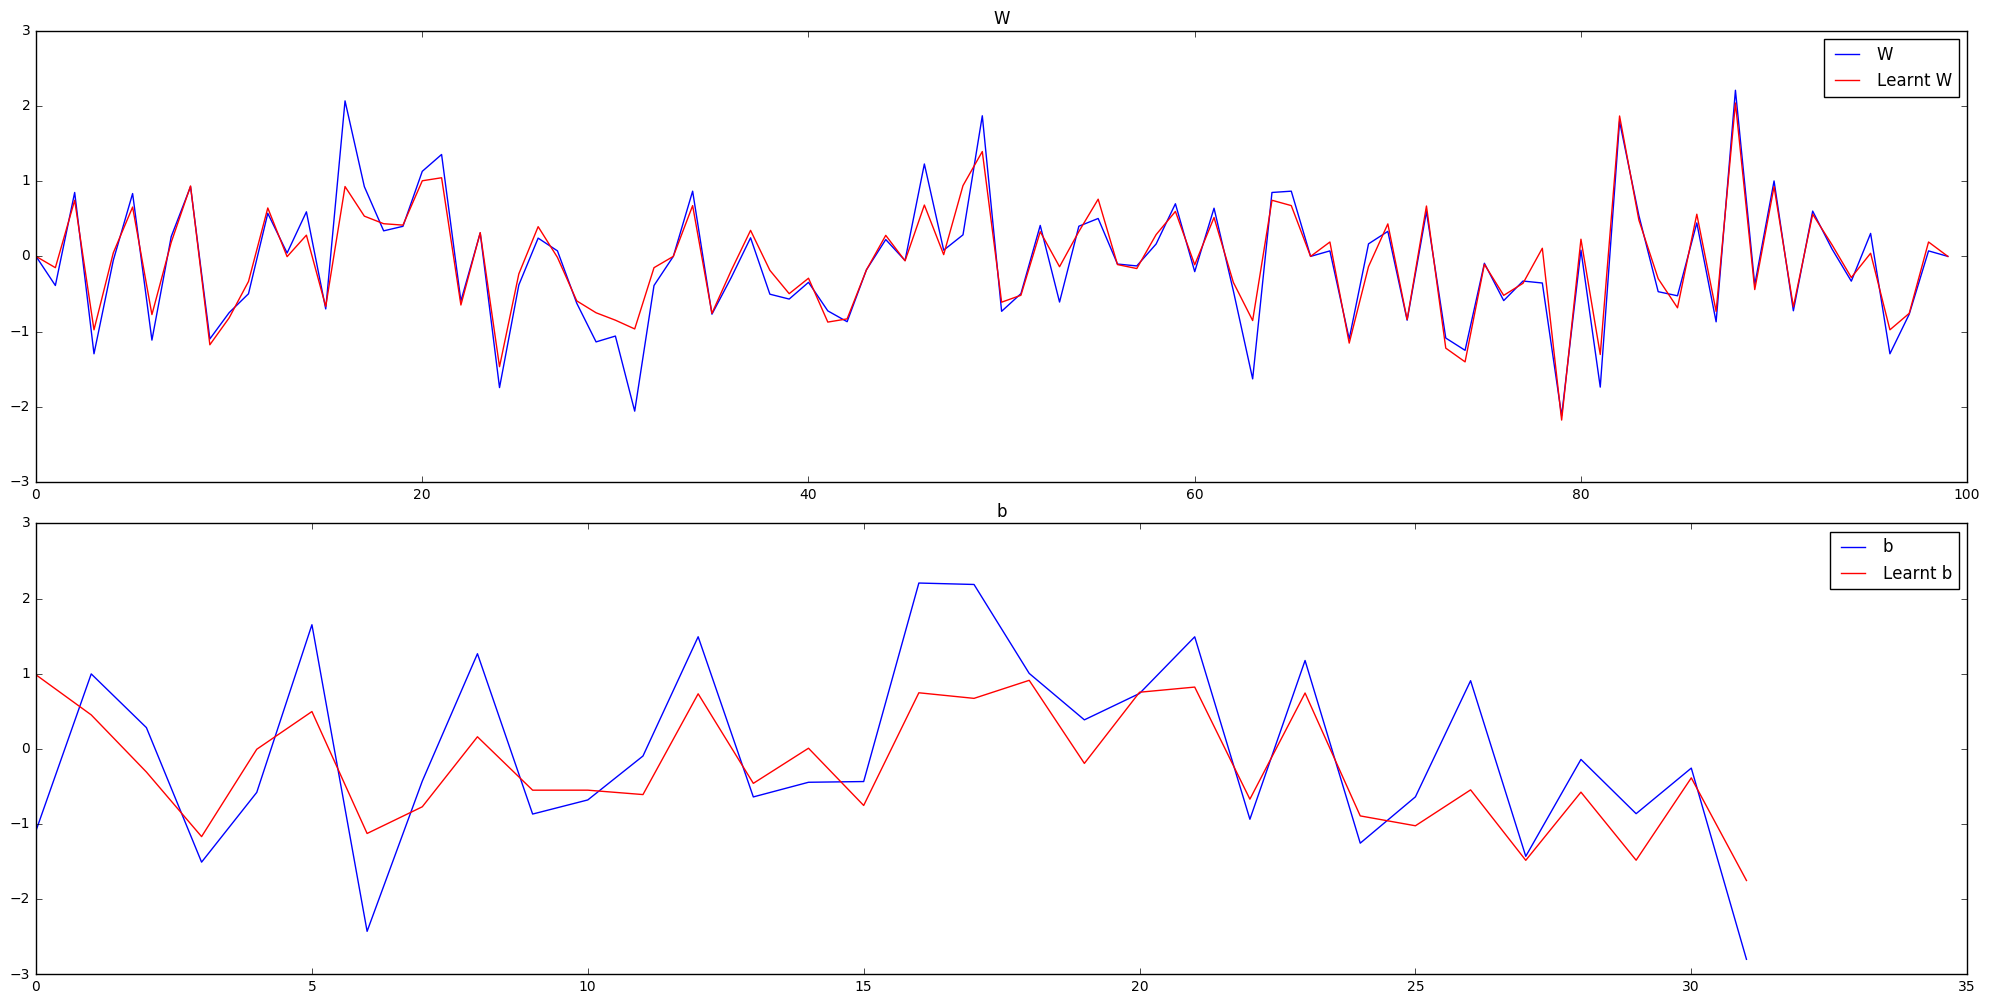

In [14]:
trainmpf(units = 32, lr = 1e-2, epsilon = 1, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '32-50K.npy')